<a href="https://colab.research.google.com/github/tsarangler/ECON3916-Statistical-Machine-Learning/blob/main/Lab_2_FRED_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install fredapi

In [17]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

fred = Fred(api_key='')


In [18]:
# 1. Fetch the data series
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# 2. Combine into a dataframe
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})

# 3. Drop missing values (The wage dat astart slater than CPI data)
df = df.dropna()

# Inspect the raw data
print(df.head())
print(df.tail())

Fetching data from FRED...
            Nominal_Wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
            Nominal_Wage      CPI
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031
2025-12-01         31.76  326.030


In [19]:
def get_real_wage(nominal_col, cpi_col):
  """
  Takes a nominal column and a CPI column.
  Returns a new column adjusted for inflation (Real Dollars).
  """
  # 1. Get the CPI of the most recent date (Today's Prices)
  # .iloc[-1] grabs the very last row in the data
  cpi_today = cpi_col.iloc[-1]

  # 2. The Formula: (Nominal/Old_CPI) * CPI_Today
  real_col = (nominal_col / cpi_col) * cpi_today

  return real_col

#Apply the function to create a new column
df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-07-01         31.35  322.132  31.729355
2025-08-01         31.45  323.364  31.709292
2025-09-01         31.52  324.368  31.681502
2025-11-01         31.73  325.031  31.827524
2025-12-01         31.76  326.030  31.760000


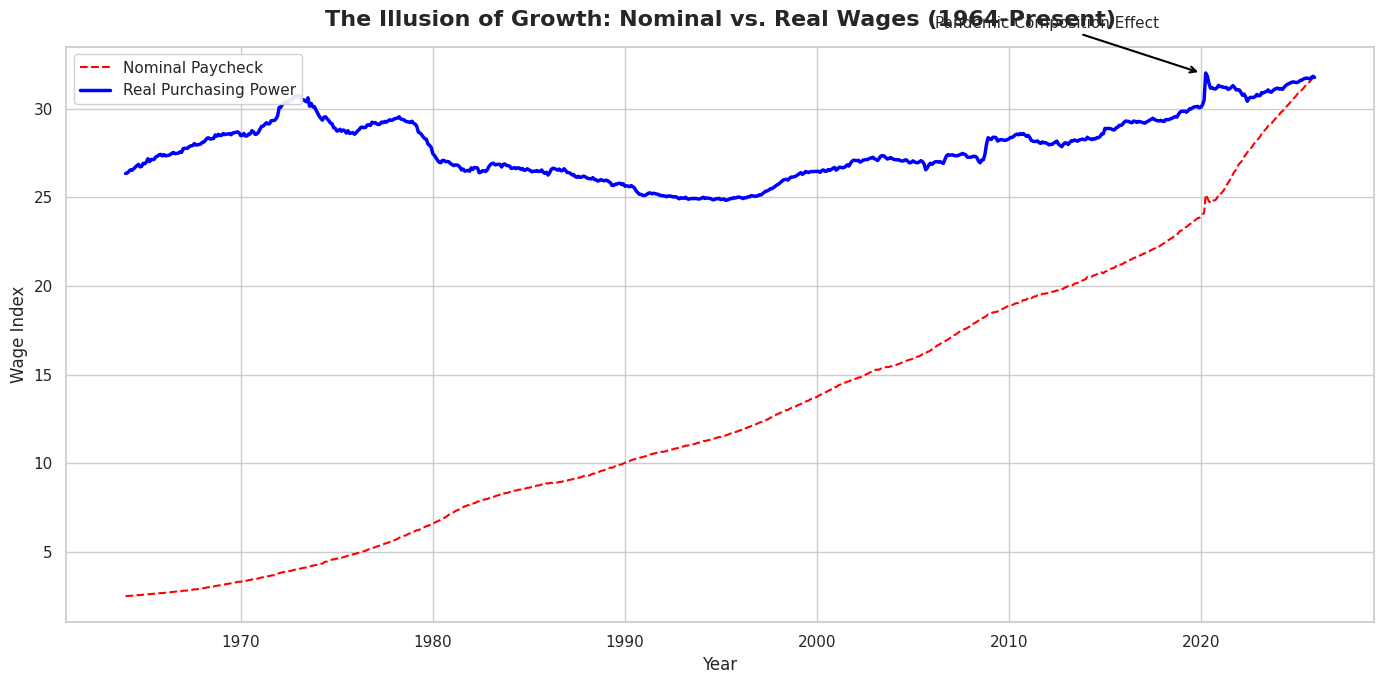

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

#Set the style and figure size
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 7))

# Plot Nominal Wage as dashed red line
ax.plot(df.index, df['Nominal_Wage'],
        linestyle='--', color='red', linewidth=1.5,
        label='Nominal Paycheck')

# Plot Real Wage as thick blue line
ax.plot(df.index, df['Real_Wage'],
        linestyle='-', color='blue', linewidth=2.5,
        label='Real Purchasing Power')

# Add title and labels
ax.set_title("The Illusion of Growth: Nominal vs. Real Wages (1964-Present)",
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Wage Index', fontsize=12)

# Add annotation arrow pointing to 2020 spike
spike_date = df.index[df.index.year == 2020][0]  # Get first 2020 date
spike_value = df.loc[df.index.year == 2020, 'Real_Wage'].max()

ax.annotate('Pandemic Composition Effect',
            xy=(spike_date, spike_value),
            xytext=(spike_date - pd.DateOffset(years=8), spike_value * 1.08),
            fontsize=11,
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
            ha='center')

# Customize legend
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)

# Improve layout
plt.tight_layout()
plt.show()

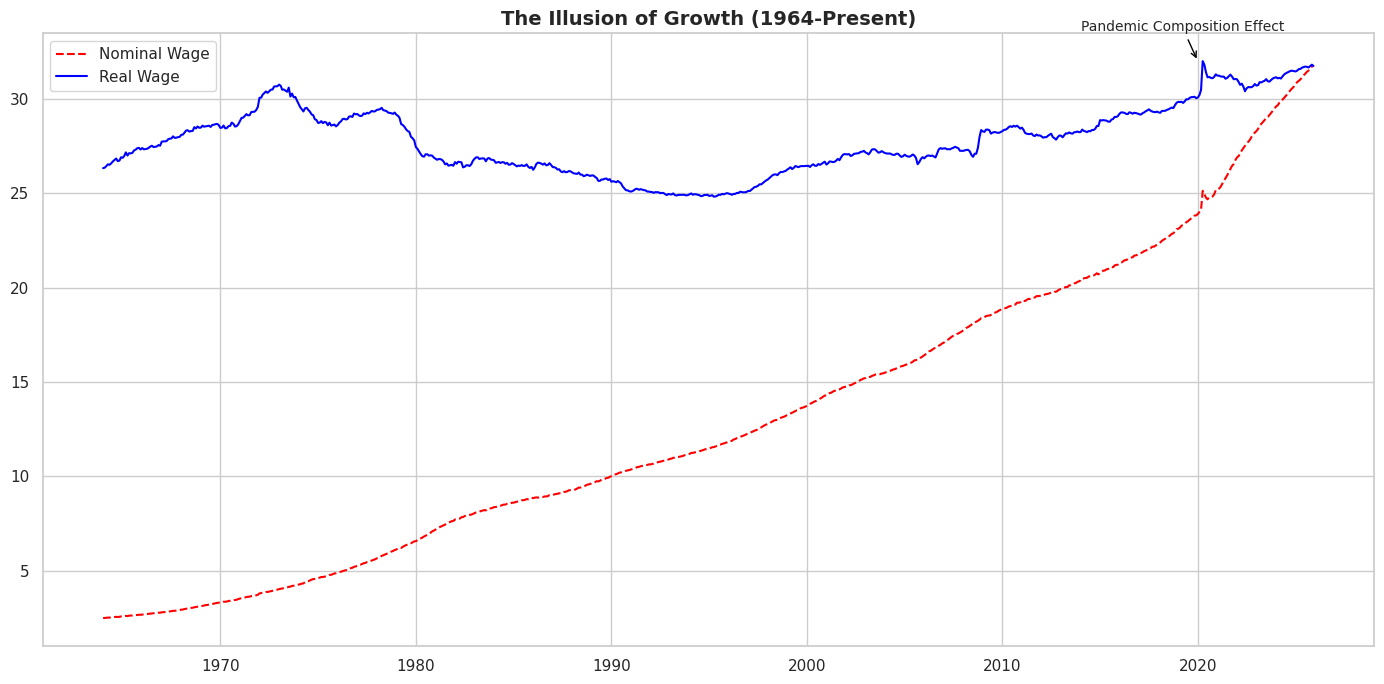

In [21]:
fig, ax = plt.subplots(figsize=(14, 7))

# Plot both wage series
ax.plot(df.index, df['Nominal_Wage'], linestyle='--', color='red', label='Nominal Wage')
ax.plot(df.index, df['Real_Wage'], linestyle='-', color='blue', label='Real Wage')

# Add title and legend
ax.set_title("The Illusion of Growth (1964-Present)", fontsize=14, fontweight='bold')
ax.legend()

# Annotate the 2020 spike
spike_date = df.index[df.index.year == 2020][0]
spike_value = df.loc[df.index.year == 2020, 'Real_Wage'].max()

ax.annotate('Pandemic Composition Effect',
            xy=(spike_date, spike_value),
            xytext=(spike_date - pd.DateOffset(years=6), spike_value * 1.05),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=10)

plt.tight_layout()
plt.show()

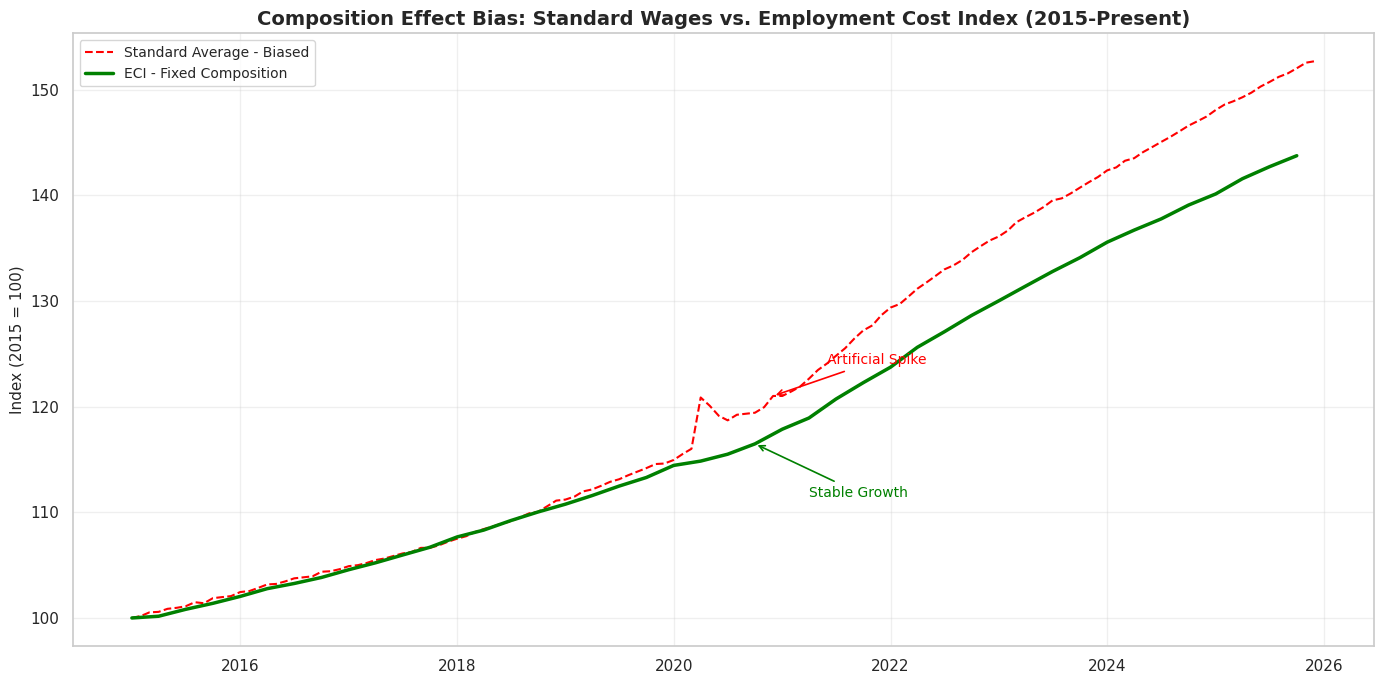

In [22]:

# Fetch the Employment Cost Index
eci = fred.get_series('ECIWAG')

# Filter both series from 2015 onwards
start_date = '2015-01-01'
wages_filtered = wages[wages.index >= start_date]
eci_filtered = eci[eci.index >= start_date]

# Rebase both series to 100 (first value = 100)
wages_rebased = (wages_filtered / wages_filtered.iloc[0]) * 100
eci_rebased = (eci_filtered / eci_filtered.iloc[0]) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(wages_rebased.index, wages_rebased,
        linestyle='--', color='red', linewidth=1.5,
        label='Standard Average - Biased')

ax.plot(eci_rebased.index, eci_rebased,
        linestyle='-', color='green', linewidth=2.5,
        label='ECI - Fixed Composition')

# Title and labels
ax.set_title("Composition Effect Bias: Standard Wages vs. Employment Cost Index (2015-Present)",
             fontsize=14, fontweight='bold')
ax.set_ylabel('Index (2015 = 100)', fontsize=11)
ax.legend(loc='upper left', fontsize=10)

# Annotate the artificial spike in standard wages (2020)
spike_date = wages_rebased.index[wages_rebased.index.year == 2020].max()
spike_value = wages_rebased[wages_rebased.index.year == 2020].max()

ax.annotate('Artificial Spike',
            xy=(spike_date, spike_value),
            xytext=(spike_date + pd.DateOffset(months=6), spike_value + 3),
            fontsize=10, color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=1.2))

# Annotate the stable growth in ECI (2020)
eci_2020_date = eci_rebased.index[eci_rebased.index.year == 2020].max()
eci_2020_value = eci_rebased[eci_rebased.index.year == 2020].max()

ax.annotate('Stable Growth',
            xy=(eci_2020_date, eci_2020_value),
            xytext=(eci_2020_date + pd.DateOffset(months=6), eci_2020_value - 5),
            fontsize=10, color='green',
            arrowprops=dict(arrowstyle='->', color='green', lw=1.2))

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()